## Module 11: Kafka & Streaming in Python

We can use Spark (through `pyspark`) to handle streaming data. We do this because Spark is popular and 

1. Fast, fault-tolerant, works with lots of software
2. Can be used with Java, Scala, Python, and R
3. Handles big data
4. Runs machine learning models on big data

Spark SQL DataFrame functions can still be used with streaming to reduce the learning curve.

Spark has at least 2 different interface to handle streaming data. 

1. Spark Streaming (more manual, customizable)
    - uses discretized streams, or `DStreams` (internally is a sequence of RDDs, which are the base object that Spark is using for data)
2. Spark Structured Streaming (much easier to use)
    - can use Spark DataFrames with SQL type functions

### Spark SQL Recap (not pandas-on-spark)

- Use `pyspark.sql.SparkSession` to create a Spark instance. 
- DataFrames are created and implemented on top of RDDs (retrieve metadata about a DataFrame using `df.printSchema()`)
- DataFrames are stored across the cluster on RDDs
    - when _transformations_ are done (e.g. `groupBy()`, `map()`, etc.), lazy evaluation is used (execution does not happen). Common transformations include `.select()` to subset columns, `.withColumn()` to create a new column from another, and `filter()` to subset via a condition. We also have summarizations (often with grouping uses `.groupBy()`) with `.avg()`, `.sum()`, `.count()`, etc.
    - when _actions_ (e.g. `show(n)`, `take(n)`, `collect()`) are done, computation starts and results are returned

Recall that DataFrame and Spark SQL share the same execution engine, so they can be used interchangeably. We can create temporary views using `df.createOrReplaceTempView("df")` and write SQL statements using `spark.sql("SELECT sex, age FROM df LIMIT 4")`.

### Spark Structured Streaming

> Spark Structured Streaming provides fast, scalable, fault-tolerant, end-to-end exactly-once processing without the user having to reason about streaming.


Spark uses micro-batching at time intervals that you set (100 milliseconds minimum). The general process is 

1. Create a Spark session (already available when running `pyspark`)
2. Read in a stream
    - stream from a file, terminal, or use something like Kafka
3. Set up transformations/aggregations to do (mostly using SQL type functions)
    - perhaps over windows
4. Write a query to implement the transformations and define output type
    - console (for debugging)
    - file (such as .csv)
    - database
5. The above won't process data until you `.start()` the query!
6. Continues for as long as specified or until you terminate it

#### Example

Do a basic word count operation using Spark SQL. To prepare the data, we'll use

- `split(str, regex, limit)` - splits `str` around occurrences that match `regex` and returns an array with a length of at most `limit`
- `explore(expr)` - separates the elements of an array `expr` into multiple rows, or the elements of map `expr` into multiple rows and columns

Once the data is prepped, we'll count the occurrences:

- use `.groupBy()` with `.count()`

The syntax will look like `df.select(["Duration", "Age", "Treatment"]).groupBy("Treatment").avg().show()`. We won't be able to use `.show()` because we're dealing with streaming data. 

##### Plan (try this with just Spark, no streaming)

1. Start a Spark session
2. Create a Spark DataFrame from an input data set (strings with words separated by spaces)
3. Split up the strings using `split()` and `explode()`
4. Count the number of times each word appears using `groupBy()` and `count()`
5. Result should be words with their associated counts

See the file `StreamingData_wordCountSparkSQL.ipynb` for an implementation of this example.

#### Example using Streaming Data

To set up a stream, we need a streaming source. One such source is Kafka, which can stream data using producers. The steps are

1. Start up Zookeeper
2. Start Kafka
3. Create a Kafka topic
4. Create a Kafka producer

Next, we follow these steps:

1. Start pyspark
2. Read in the Kafka stream (`.readStream`)
3. Process it to count words (`split()` and `explode()` with `groupBy()` and `count()`)
4. Write the output to the console (`.writeStream`)
5. Start the query and begin sending data

On a Mac M1 (Apple Silicon) you can install Kafka using `brew` with 

`$ brew install kafka`

You can start Zookeeper with 

`$ zookeeper-server-start /opt/homebrew/etc/kafka/zookeeper.properties`

You can then start Kafka with

`$ kafka-server-start /opt/homebrew/etc/kafka/server.properties`

We then need to create a Kafka _topic_ and a Kafka _producer_ that will send out data. The line below creates the topic:

`$ kafka-topics --create -topic mystream --bootstrap-server localhost:9092`

The line below creates the producer:

`$ kafka-console-producer --topic mystream --bootstrap-server localhost:9092`

Then, we can run

`$ pyspark --packages org.apache.spark:spark-sql-kafka-0-10_2.13:3.2.1`

### Reading and writing streams with Spark Structured Streaming

We're going to closely follow the [Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html). 

Recall that the general steps we follow are:

1. Create a Spark session (already available when running `pyspark`)
2. Read in a stream
    - stream from a file, terminal, or use something like Kafka
3. Set up transformations/aggregations to do (mostly using SQL type functions)
    - perhaps over windows
4. Write a query to implement the transformations and define output type
    - console (for debugging)
    - file (such as .csv)
    - database
5. The above won't process data until you `.start()` the query!
6. Continues for as long as specified or until you terminate it

Streaming data frames are slightly different from the Spark SQL DataFrames. 

- Streaming data frames are **unbounded** and the schema is only checked at runtime. Unbounded table means that there is no concrete number of rows - it simply keeps growing. As data comes in, new data in the data streams = new rows appended to an unbounded table.
- Rows are added incrementally

When a query is started, Spark will check for new data at some specified interval (default is 100 milliseconds). If there is new data, Spark will run an "incremental" query that combines the previous running counts with the new data to compute updated counts. 

#### How do we read in a stream?

We can read streaming data using the [`DataStreamReader`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.streaming.DataStreamReader.html) interface (`SparkSession.readStream`). 


* `.readStream` has different methods to customize/set up how to read the stream. 
    - `.format()` - generic, specifies the input source, such as "kafka"
    - `.option(key, value)` - allows an input option on a file source
    - `.load()` - actually load the data into a data stream and return a DataFrame

An example is provided below:

```
df = spark \
.readStream \
.format("kafka") \
.option("subscribe", "mystream") \ # subscribe to a topic called "mystream"
.option("kafka.bootstrap.servers", "localhost:9092") \
.load()
```

For testing purposes, we will also use `rate`. The example below produces data with a time stamp that increments every second.

```
df = spark \
.readStream \
.format("rate") \
.option("rowsPerSecond", 1) \
.load()
```

What if we are not reading from a generic source, but from a source that is more common and structured? We can still use `.option()`, but we will also often use 

- `.schema()` - explicitly specify the schema
- `.csv(path)` - load data from a CSV stream
- `.json(path)` - load data from a JSON file stream
- ... (other types of files)

We do not need to use `.load()` because the two methods above automatically load for us.

As an example of reading from a CSV, we can run

```
# Read all of the CSV files written automatically in a directory

# Specify a schema for the CSV file. We will have a 
# variable called "name" that is a string variable and a
# variable called "age" that is an integer

userSchema = StructType().add("name", "string").add("age", "integer") 

# Read in the data
csvDF = spark \
    .readStream \
    .option("sep", ";") \ # separator is not a comma but a semi-colon
    .schema(userSchema) \ 
    .csv("/path/to/directory")
```

In a terminal, we can run

`$ rateDF = spark.readStream.format("rate").load()`

`$ writeRate = rateDF.writeStream.format("console").outputMode("append").start()`

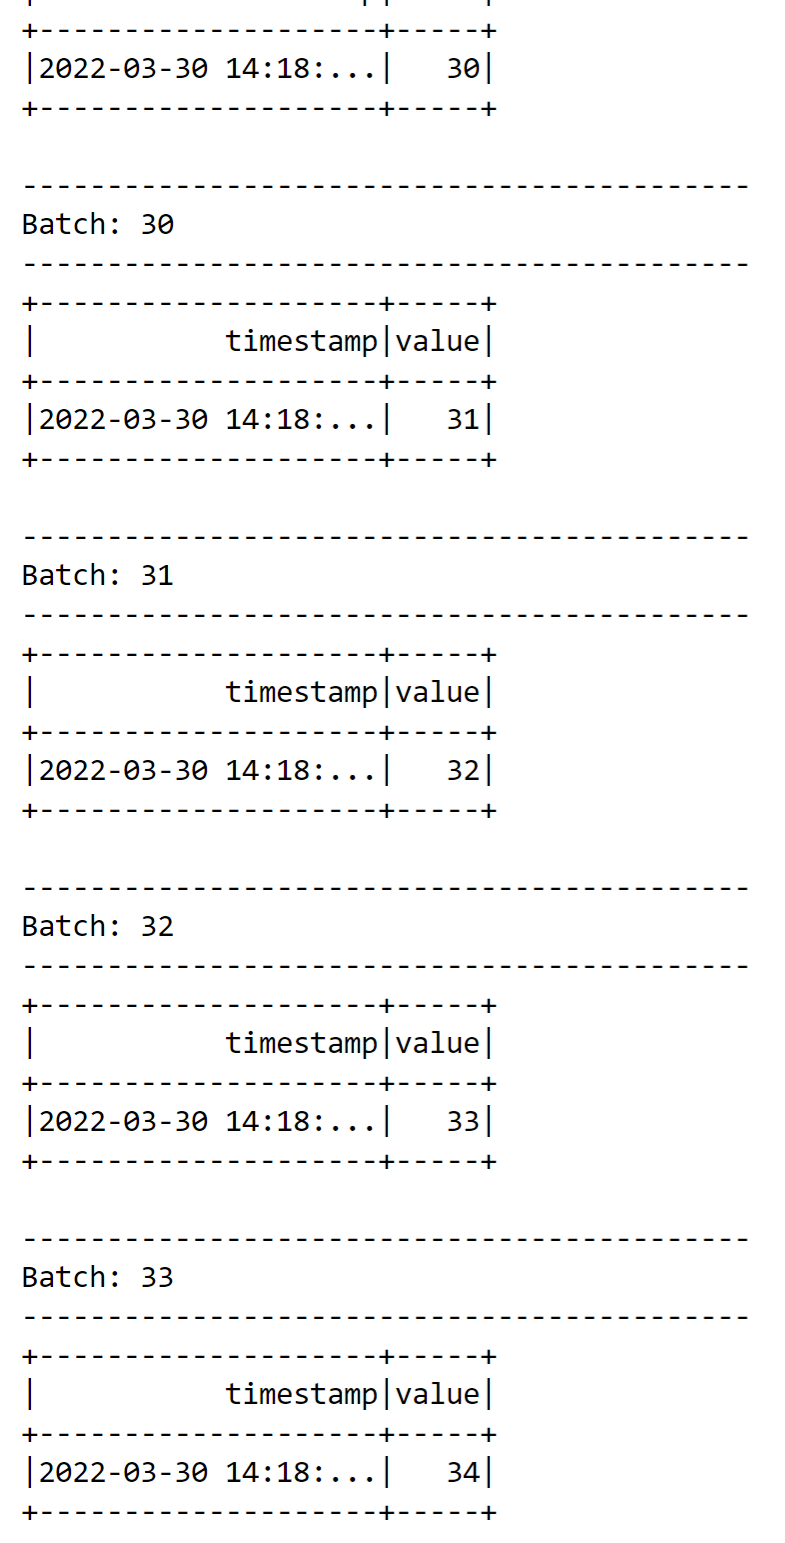

We can stop the stream using `writeRate.stop()`. 

To start our query, we need to specify how we're going to output our information and where we're going to output it. To do this, we need to use the `DataStreamWriter` interface (`df_with_transforms_etc.writeStream`). `.writeStream` has different methods to customize the output type and location. **Output type** includes

- **complete** - print entire table at each update
    - only supported for aggregation queries
- **append** (default) - only new rows added to the results table are outputted
    - only applicable if rows added can never change (say from late data)
- **update** - similar to append but allows flexibility if data may change

**Output sinks** (where we'll output data) include

- **console** sink (mainly for debugging)
    - `query.writeStream.outputMode("complete").format("console").start()`
- **memory** - stores output in an in-memory table that you can investigate
    - `query.writeStream.format("memory").queryName("tableName").start()
- **file** sink (CSV, JSON, Parquet, etc.)
    - `query.writeStream.outputMode("append").format("csv").option("path", "path_to_file").start()`
- **Kafka** sink

We need to use `.start()` to begin and output will be based on _triggers_. We set triggers using `trigger(*[, processingTime, once, continuous])`. The default trigger uses micro-batches which are generated as soon as the previous micro-batch has completed processing. We also have the option of fixed-interval micro-batches, which can be set up using `writeStream...trigger(processingTime = "2 seconds")...`, and one-time micro-batch, which executes once and shuts itself down (essentially a quick udpdate since you last ran the query). One-time micro-batches can be triggered with `writeStream...trigger(once = True)...`. There is the option of a _continuous_ trigger, but this is experimental. 

#### Multiple queries and stopping queries

We can run multiple queries at once and share resources. To view a list of all active streaming queries, we can run `spark.streams.active`. To stop a query, we can run `query.stop()`, where `query` is the name of the query. Spark also has a GUI for monitoring, which can be accessed at `http://localhost:4040/`. 

#### Example - read in a .csv file from a folder

Spark looks for any new .csv files added to a folder. When a new file is added, its content are red it. All files must have the same schema!

### Transformations, windowing, and aggregation

To perform aggregations over and event-time window, we need a time stamp or event-time on the data. Due to delays, event-time may be different than the time that an event was received by Spark!

Windowing is easy to do. We simply use `groupBy()` and specify the window size and the update time:

```
df.gropBy(
    window(df.timestamp, "1 minute", "30 seconds"), # 2nd arg is window size, 3rd update time
    other_grouping_var,
    ).aggregation
```

For data that comes in late, Spark can provide a **watermark**. This acts as a threshold for how late our incoming data can be, and data states are maintained until the window AND that threshold are reached. 

The example below shows how to set up a watermark:

```
# "timestamp" is the name of the column on which we use our watermark
df \
    .withWatermark("timestamp", "20 seconds") \ # accept data 20 seconds past the close of the window
    .groupBy(
      window(df.timestamp, "1 minute", "30 seconds"), #2nd arg is window size, 3rd update time
      other_grouping_var
    ) \
    .aggregation()
```

There are 3 types of time windows in Spark:

1. Tumbling - set the window time to update time
2. Sliding - can overlap
3. Session - corresponds to updating only when your query is run

### Streaming joins

Occasionally, we may want to combine two streams or a stream and static data.

Recall that combining two (or more) tables in SQL is called doing a **join**. 

- An _inner join_ returns records with matching keys in both tables. 
- A _left (outer) join_ returns everything from the "left" table and any matching records from the "right" table
- A (full) outer join returns all records when there is a match from the left or right table (returns everything)

#### Stream to stream

With stream to stream, we can do

- inner
- left (must specify watermark on right and time constraints)
    - right works similarly
- full outer (must specify watermark and time constraints on at least one side)
- left semi (return any rows from the left dataset that were matched with the right table)

We also must use the **append** output mode. We also cannot do agrgegations before joins.

What is the syntax we want to use?

##### Inner join

```
# Inner join on common column col_id
streamDF1.join(streamDF2, "col_id") 
```

##### Left (outer) join syntax

```
# Left (outer) join syntax
# Each has some watermarks

# Define watermarks
impressionsWithWatermark = impressions \
    .selectExpr("adId AS impressionAdId", "impressionTime") \ # rename column
    .withWatermark("impressionTime", "10 seconds ") # max 10 seconds late

clicksWithWatermark = clicks \
    .selectExpr("adId AS clickAdId", "clickTime") \ # rename column
    .withWatermrk("clickTime", "20 seconds") # max 20 seconds late
    
    
from pyspark.sql.functions import expr

# Left outer join with time range conditions
impressionsWithWatermark.join(
    clicksWithWatermark,
    expr("""
        clickAdId = impressionAdId AND
        clickTime >= impressionTime AND
        clickTime <= impressionTime + interval 1 hour
        """),
    "leftOuter" # type of join we're doing
)
```

#### Stream to static joins

Suppose streaming DataFrame is on the left and static is on the right. We can do the following joins:

- inner
- left outer
- left semi

##### Example syntax

```
streamingDF.join(staticDF, "column", "inner")
```

We then need to write the query!